In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import numpy as np

2025-10-18 18:31:51.424814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760812311.677485      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760812311.751773      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.applications import EfficientNetB0

In [3]:
# Access your Kaggle dataset
DATASET_PATH = "/kaggle/input/upi-payment-screenshots/dataset_split"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Parameters
input_shape = (224, 224, 3)  # Standard input size for EfficientNetB0
batch_size = 32
num_classes = 6  # fampay, gpay, phonepe, invalid, misc, paytm

# Print classes for verification
class_folders = os.listdir(TRAIN_DIR)
print(f"Found classes: {class_folders}")
print(f"Total number of classes: {len(class_folders)}")

Found classes: ['misc', 'gpay', 'phonepe', 'fampay', 'invalid', 'paytm']
Total number of classes: 6


In [4]:
# Create data generators - since your data is already preprocessed and augmented
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224, 224),
    batch_size=batch_size
)

# Store class names before applying optimizations
class_names = train_ds.class_names
print("Class mapping:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

# Now optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 508 files belonging to 6 classes.


I0000 00:00:1760812325.589905      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760812325.590631      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 131 files belonging to 6 classes.
Class mapping:
0: fampay
1: gpay
2: invalid
3: misc
4: paytm
5: phonepe


In [5]:
# Create the base model from EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,  # Remove the classification head
    weights="imagenet",  # Use pre-trained weights
    input_shape=input_shape,
    pooling="avg"  # Use global average pooling
)

# Freeze the base model
base_model.trainable = False

# Print summary of the base model
print("Base model summary:")
base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model summary:


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# Build the model with custom classification head
inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.Dropout(0.2)(x)  # Add dropout for regularization
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Print summary of the full model
print("Full model summary:")
model.summary()

Full model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Add callbacks for better training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_upi_model.keras", 
        save_best_only=True, 
        monitor="val_accuracy"
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=3, 
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=2, 
        min_lr=1e-6
    )
]

In [8]:
# Initial training with frozen base model
initial_epochs = 10
print("Starting initial training phase...")

history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    callbacks=callbacks
)

# Save initial model
model.save("initial_upi_model.keras")

# Evaluate initial model
initial_loss, initial_accuracy = model.evaluate(test_ds)
print(f"Initial model accuracy: {initial_accuracy:.2%}")

Starting initial training phase...
Epoch 1/10


I0000 00:00:1760812343.254475     105 service.cc:148] XLA service 0x79d934113b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760812343.255478     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760812343.255500     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760812345.139681     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2639 - loss: 1.7525 

I0000 00:00:1760812354.676336     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1836 - loss: 1.8367 - val_accuracy: 0.2366 - val_loss: 1.7640 - learning_rate: 1.0000e-04
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.2392 - loss: 1.7765 - val_accuracy: 0.3435 - val_loss: 1.6896 - learning_rate: 1.0000e-04
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3542 - loss: 1.6671 - val_accuracy: 0.3740 - val_loss: 1.6294 - learning_rate: 1.0000e-04
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4198 - loss: 1.6041 - val_accuracy: 0.4122 - val_loss: 1.5746 - learning_rate: 1.0000e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4381 - loss: 1.5565 - val_accuracy: 0.4656 - val_loss: 1.5244 - learning_rate: 1.0000e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4561 - loss: 1.5334 - val_accuracy: 0.4733 - val_loss: 1.4765 - learning_rate: 1.0000e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4607 - loss: 1.47

In [9]:
# Fine-tuning
print("Starting fine-tuning phase...")
base_model.trainable = True

# Freeze earlier layers, unfreeze later layers
# We'll unfreeze the top 30 layers while keeping the others frozen
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Count trainable parameters
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")

# Recompile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_ds,
    callbacks=callbacks
)

# Save final model
model.save("final_upi_classifier_model.keras")

Starting fine-tuning phase...
Trainable parameters: 1,501,542
Non-trainable parameters: 2,555,715.0
Epoch 11/20


E0000 00:00:1760812411.590746     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760812411.730229     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4321 - loss: 1.5447

E0000 00:00:1760812423.435267     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760812423.574523     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4329 - loss: 1.5436 - val_accuracy: 0.6489 - val_loss: 1.2535 - learning_rate: 1.0000e-05
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.4978 - loss: 1.4386 - val_accuracy: 0.6870 - val_loss: 1.2107 - learning_rate: 1.0000e-05
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5629 - loss: 1.3689 - val_accuracy: 0.6947 - val_loss: 1.1722 - learning_rate: 1.0000e-05
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6053 - loss: 1.3215 - val_accuracy: 0.7176 - val_loss: 1.1339 - learning_rate: 1.0000e-05
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6210 - loss: 1.2624 - val_accuracy: 0.7023 - val_loss: 1.0940 - learning_rate: 1.0000e-05
Epoch 16/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7080 - loss: 1.1769 - val_accuracy: 0.7328 - val_loss: 1.0510 - learning_rate: 1.0000e-05
Epoch 17/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7098 - los

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8013 - loss: 0.8755
Initial model accuracy: 57.25%
Final model accuracy: 81.68%
Improvement: 24.43%


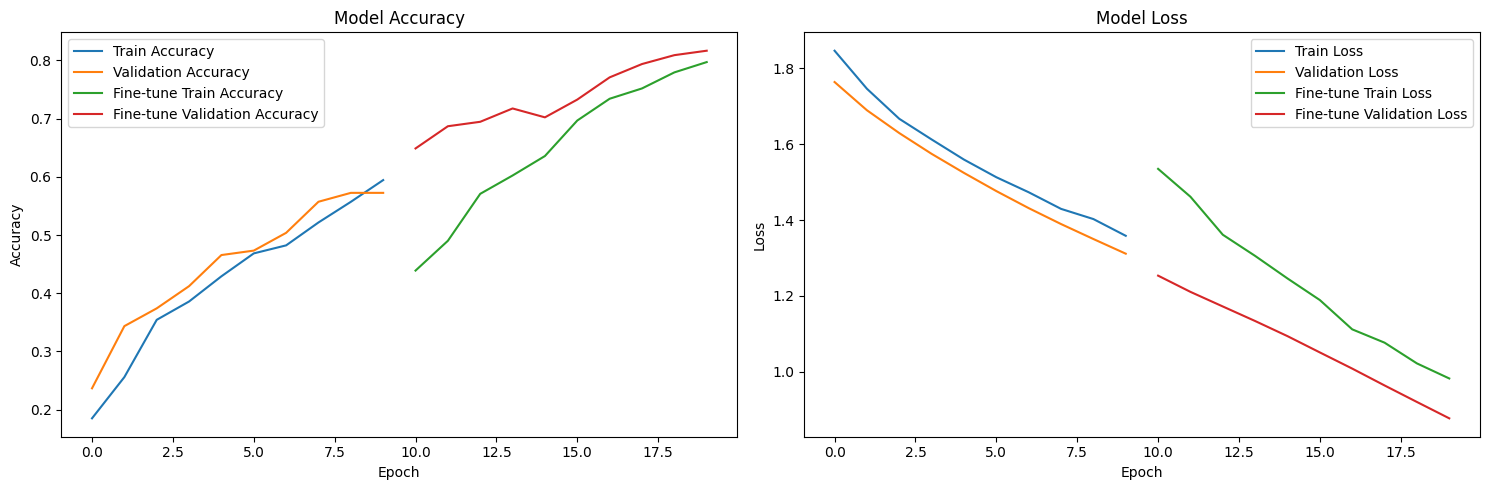

In [10]:
# Evaluate on test set
final_loss, final_accuracy = model.evaluate(test_ds)
print(f"Initial model accuracy: {initial_accuracy:.2%}")
print(f"Final model accuracy: {final_accuracy:.2%}")
print(f"Improvement: {(final_accuracy - initial_accuracy):.2%}")

# Plot training history
def plot_history(history1, history2=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history1.history['accuracy'], label='Train Accuracy')
    ax1.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    
    if history2:
        epochs_range = range(len(history1.history['accuracy']))
        fine_tune_range = range(
            len(history1.history['accuracy']), 
            len(history1.history['accuracy']) + len(history2.history['accuracy'])
        )
        
        ax1.plot(fine_tune_range, history2.history['accuracy'], label='Fine-tune Train Accuracy')
        ax1.plot(fine_tune_range, history2.history['val_accuracy'], label='Fine-tune Validation Accuracy')
    
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history1.history['loss'], label='Train Loss')
    ax2.plot(history1.history['val_loss'], label='Validation Loss')
    
    if history2:
        ax2.plot(fine_tune_range, history2.history['loss'], label='Fine-tune Train Loss')
        ax2.plot(fine_tune_range, history2.history['val_loss'], label='Fine-tune Validation Loss')
    
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Model Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Plot training history
plot_history(history, history_fine)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


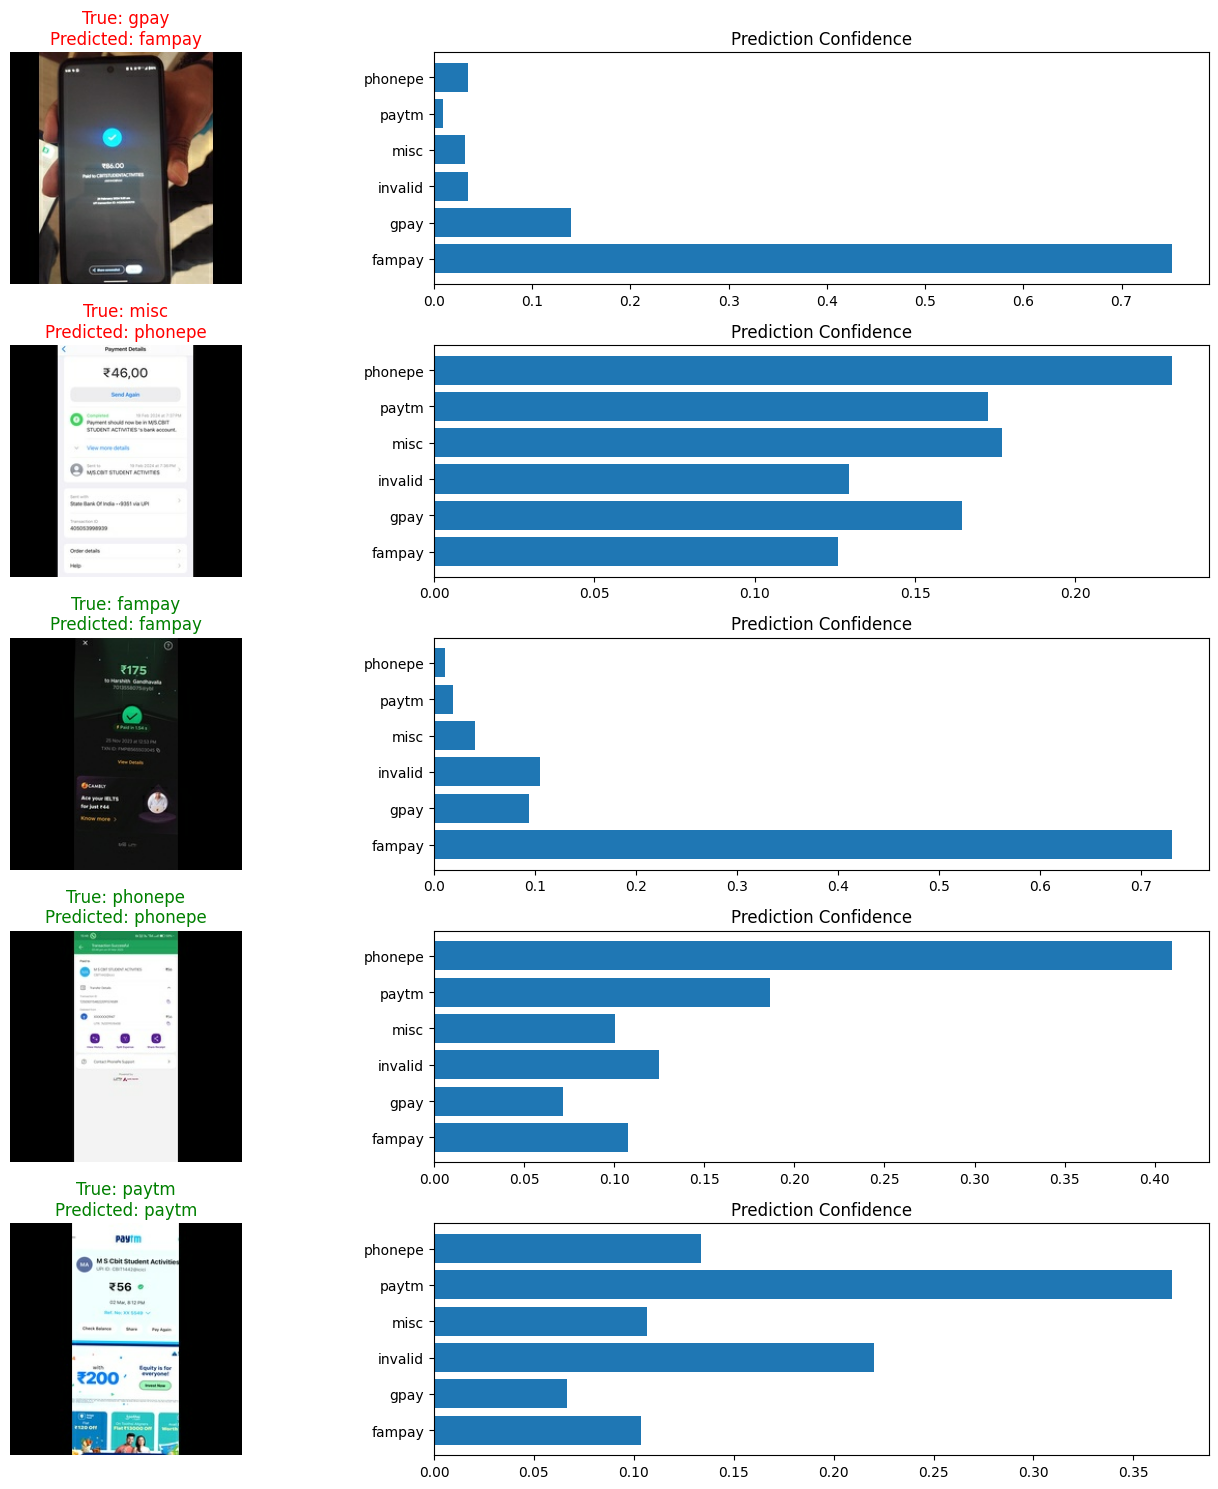

In [11]:
# Create a function to make and visualize predictions
def predict_and_visualize(model, dataset, num_images=5):
    # Get a batch of images and labels
    images, labels = next(iter(dataset))
    
    # Select a subset of images
    selected_indices = np.random.choice(len(images), min(num_images, len(images)), replace=False)
    selected_images = tf.gather(images, selected_indices)
    selected_labels = tf.gather(labels, selected_indices)
    
    # Make predictions
    predictions = model.predict(selected_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Plot images with predictions
    plt.figure(figsize=(15, 3*num_images))
    
    for i in range(len(selected_images)):
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(selected_images[i].numpy().astype("uint8"))
        
        true_label = class_names[selected_labels[i]]
        predicted_label = class_names[predicted_classes[i]]
        
        title_color = "green" if predicted_classes[i] == selected_labels[i] else "red"
        
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}", 
                 color=title_color)
        plt.axis("off")
        
        # Plot prediction confidence
        plt.subplot(num_images, 2, 2*i+2)
        confidence = predictions[i]
        plt.barh(class_names, confidence)
        plt.title("Prediction Confidence")
        
    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Visualize predictions on test data
predict_and_visualize(model, test_ds.take(1), num_images=5)

In [12]:
#import shutil
#shutil.move("final_upi_classifier_model.keras", "/kaggle/working/final_upi_classifier_model.keras")

'/kaggle/working/final_upi_classifier_model.keras'

In [23]:
import json
import os
import tensorflow as tf

# Assuming 'model' variable is still in memory from training
# If not, load it first: model = tf.keras.models.load_model("final_upi_classifier_model.keras")

SAVE_DIR = "/kaggle/working/upi_classifier_weights"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save model weights instead of full model
weights_path = os.path.join(SAVE_DIR, "model_weights.weights.h5")
model.save_weights(weights_path)
print(f"✓ Weights saved to: {weights_path}")

# Save model architecture as JSON
model_json = model.to_json()
architecture_path = os.path.join(SAVE_DIR, "model_architecture.json")
with open(architecture_path, 'w') as f:
    f.write(model_json)
print(f"✓ Architecture saved to: {architecture_path}")

# Save metadata
CLASS_NAMES = ['fampay', 'gpay', 'invalid', 'misc', 'paytm', 'phonepe']
metadata = {
    "class_names": CLASS_NAMES,
    "num_classes": len(CLASS_NAMES),
    "input_shape": [224, 224, 3],
    "model_type": "EfficientNetB0_Transfer_Learning",
    "normalization": "none",
    "pixel_range": [0, 255],
    "tensorflow_version": tf.__version__,
    "keras_version": tf.keras.__version__
}

metadata_path = os.path.join(SAVE_DIR, "model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*60)
print("WEIGHTS PACKAGE READY!")
print("="*60)
print("\nDownload these files:")
print("  1. model_weights.weights.h5")
print("  2. model_architecture.json")
print("  3. model_metadata.json")

✓ Weights saved to: /kaggle/working/upi_classifier_weights/model_weights.weights.h5
✓ Architecture saved to: /kaggle/working/upi_classifier_weights/model_architecture.json
✓ Metadata saved to: /kaggle/working/upi_classifier_weights/model_metadata.json

WEIGHTS PACKAGE READY!

Download these files:
  1. model_weights.weights.h5
  2. model_architecture.json
  3. model_metadata.json
